# Langevin Equation Test Case (p0q0)

## Producing the data

For this notebook we consider the stochastic overdamped Langevin equation with a double-welled potential $V(x) = \frac{1}{4}(x^2 - 1)^2$. So, we consider the following SDE. 
$$dX_t = -X_t(X_t^2 - 1)dt + dB_t$$
To find a numerical solution we first use the Euler-Maruyama scheme 
$$X_{n+1} = X_n - h X_n(X_n^2 - 1) + \nu_n$$
here $$\nu_n \sim (B_{t_{n+1}}-B_{t_{n}}) \sim N(0,h) \sim \sqrt{h} N(0,1).$$

Now we generate the sample path.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as sa
import scipy.optimize as so

In [2]:
start = 0
stop = 10**4
steps = stop*100 + 1

dVdx = lambda x : -x*(x**2 -1) 

x_init = .5

In [3]:
h = (stop - start)/(steps - 1)
t = np.linspace(start,stop,steps)

X = np.zeros(steps)
X[0] = x_init

for n in range(steps - 1):
    X[n+1] = X[n] + h*dVdx(X[n]) + np.sqrt(h)*np.random.normal(0,1)

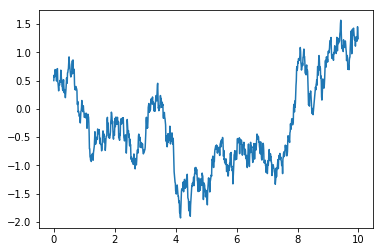

In [4]:
plt.plot(t[:1000],X[:1000])

In [5]:
def sim(X,Psi,A_init):
    N = len(X)
    
    A_sol = A_init
        
    # Then we run it
    b = A_sol

    Y = np.zeros(N)
    Y[0] = X[0]
    for i in range(1,N-1):
        Y[i] = b @ Psi(Y[i-1]) + np.sqrt(abs(b[0]))*np.random.normal(0,1)
    return Y

The graph below display two realizations of the same stochastic process.

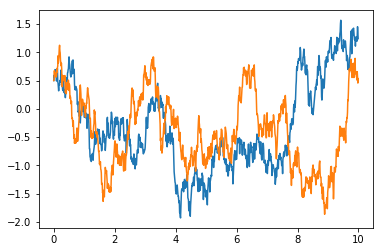

In [6]:
Psi = lambda x : np.array([dVdx(x), x])
A_init = [h,1]
Y = sim(X,Psi,A_init)
plt.plot(t[:1000],X[:1000])
plt.plot(t[:1000],Y[:1000])

In [7]:
np.mean(X),np.mean(Y)

(0.006132593326984596, -0.03454198522528857)

In [8]:
np.var(X),np.var(Y)

(0.88930130188933, 0.8908393943054237)

## Proposing the test

We seek to fit something of the form $p = 0$, $q=0$

\begin{align}
Y_{n+1} &=\Psi(Y_n) b_0 +\xi_{n+1} \\
\end{align}
where $\Psi(x) =(-x(x^2 - 1),x)$, $Y_{0} = X_{0}$. This coresponds to a NARMAX model.

To fit we use for our loss function the mean squared one-step error:
$$\frac{1}{N}\sum_{n=1}^{N} \|X_{n} - Y_{n}\|^2.$$ 
So that the mimimization problem may be rendered as follows:
\begin{align}
\min_{a,b} &\frac{1}{N}\sum_{n=1}^{N} \|X_{n} - Y_{n}\|^2 \\
\text{s.t. } & Y_0 = X_0 \\
& Y_{n+1} =\Psi(Y_n) b_0 \qquad \text{for } n = 0,\dots, N-1 \\
\end{align}

It is clear that if $b_0 = \begin{pmatrix} h \\ 1 \end{pmatrix}$, then the NARMAX model above for $Y_n$ and the Euler-Maruyama scheme for $X_n$ are different formulations of the same discrete time stochastic process.
And so, we expect there to be a local minimum to the optimization problem at $A = (\vec{b}) = (h,1)$ where $\vec{b} = b_0^T$. 

The optimization problem above is coded as follows. 

In [13]:
def modReduction(X,Psi,A_init):
    N = len(X)
    
    def aux_fun(A, X, Psi, N):
        b = A
        
        Y = np.zeros(N)
        Y[0] = X[0]
        for i in range(N-1):
            Y[i+1] = b @ Psi(X[i])
        return X - Y

    obj_fun = lambda A : aux_fun(A, X, Psi, N)
    
    A_sol = so.least_squares(obj_fun,A_init).x
        
    # Then we run it
    b = A_sol

    Y = np.zeros(N)
    Y[0] = X[0]
    for i in range(1,N-1):
        Y[i] = b @ Psi(Y[i-1]) + np.sqrt(abs(b[0]))*np.random.normal(0,1)
    return [Y,A_sol]


Now to implement this. First, we set $\Psi$ and an initial guess at the parameters $a$ and $b$, we let $A = (a,\vec{b})$. 

## Preparing for fitting

In [10]:
n_disc = 50

## Fitting

To fit we use the information above which suggests we discard the first 40 seconds of samples. 

In [11]:
Z = X[n_disc:]

In [14]:
A_init = [0,0]
[Y,A_sol] = modReduction(Z,Psi,A_init)
A_sol

array([0.00994249, 0.99995597])

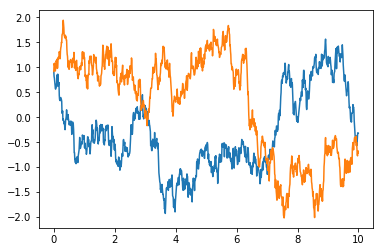

In [15]:
plt.plot(t[:1000],Z[:1000])
plt.plot(t[:1000],Y[:1000])

In [16]:
np.mean(Y),np.mean(Z)

(0.018053993246697413, 0.006107978695170647)

In [17]:
np.var(Y),np.var(Z)

(0.8859789718070727, 0.8893326842670916)

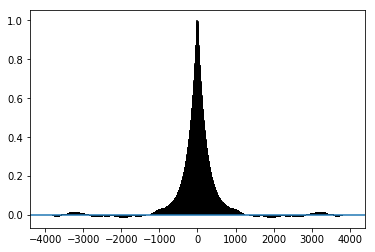

In [18]:
maxlags = 4000
[lags,c] = plt.acorr(Z,maxlags = maxlags)[:2]

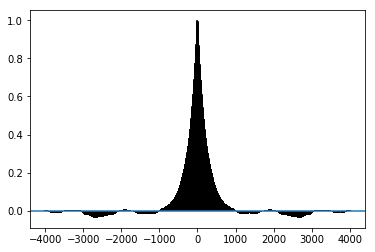

In [19]:
maxlags = 4000
[lags,c] = plt.acorr(Y,maxlags = maxlags)[:2]